In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [2]:
# %%file node_setup/cre_setup_3_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 11, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,

In [3]:
# %%file node_setup/cre_setup_1_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,
# 11, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [4]:
# %%file node_setup/cre_setup_3_scale_5_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,
# 36, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 36,
# 37, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 37,
# 38, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 38,
# 39, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 39,
# 40, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 40,
# 41, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 41,
# 42, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 42,
# 43, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 43,
# 44, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 44,
# 45, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 46, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 47, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 55,
# 58, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 56,
# 59, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 57,
# 60, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 58,
# 61, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 59,
# 62, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 60,
# 63, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 61,
# 64, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 62,
# 65, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 63,
# 66, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 64,
# 67, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 65,
# 68, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 66,
# 69, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 67,
# 70, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 68,
# 71, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 69,
# 72, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,




In [5]:
# %%file node_setup/cre_setup_2_scale_5_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,

# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 35,
# 36, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 36,
# 37, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 37,
# 38, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 38,
# 39, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 39,
# 40, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 40,
# 41, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 41,
# 42, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 42,
# 43, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 43,
# 44, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 44,

# 45, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 46, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 47, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 55,
# 58, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 56,
# 59, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 57,
# 60, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 58,
# 61, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 59,
# 62, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 60,
# 63, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 61,
# 64, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 62,
# 65, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 63,
# 66, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 64,
# 67, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 65,
# 68, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 66,
# 69, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 67,
# 70, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 68,
# 71, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 69,

# 72, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [6]:
# %%file node_setup/cre_setup_1_scale_5_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,

# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 34,

# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,
# 36, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 36,
# 37, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 37,
# 38, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 38,
# 39, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 39,
# 40, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 40,
# 41, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 41,
# 42, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 42,
# 43, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 43,
# 44, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 44,

# 45, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 46, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 47, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 55,
# 58, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 56,
# 59, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 57,
# 60, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 58,
# 61, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 59,
# 62, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 60,
# 63, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 61,
# 64, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 62,
# 65, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 63,
# 66, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 64,
# 67, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 65,
# 68, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 66,
# 69, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 67,
# 70, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 68,
# 71, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 69,

# 72, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [7]:
# %%file node_setup/cre_setup_2_scale_1_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 10, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,
# 11, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 9,
# 12, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 10,
# 13, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 11,
# 14, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 12,
# 15, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 13,
# 16, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [8]:
# %%file node_setup/cre_setup_3_scale_2_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 19, 'europe-west3-c', 1, -1, 'FKA.pem', 1, -1,
# 20, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 18,
# 21, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 19,
# 22, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 20,
# 23, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 21,
# 24, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 22,
# 25, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 23,
# 26, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 24,
# 27, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 25,
# 28, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 26,
# 29, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 27,
# 30, 'asia-south1-c', 1, -1, 'FKE.pem', 2, -1,

In [9]:
# %%file node_setup/cre_setup_3_scale_3_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
# 1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
# 2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
# 3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
# 4, 'ap-south-1', 0, 0, 'FKA.pem', -1, 4,
# 5, 'ap-south-1', 0, 0, 'FKA.pem', -1, 5,
# 6, 'ap-south-1', 0, 0, 'FKA.pem', -1, 6,
# 7, 'ap-south-1', 0, 0, 'FKA.pem', -1, 7,
# 8, 'ap-south-1', 0, 0, 'FKA.pem', -1, 8,
# 9, 'ap-south-1', 0, 0, 'FKA.pem', -1, 9,
# 10, 'ap-south-1', 0, 0, 'FKA.pem', -1, 10,
# 11, 'ap-south-1', 0, 0, 'FKA.pem', -1, 11,
# 12, 'ap-south-1', 0, 1, 'FKA.pem', -1, 12,
# 13, 'ap-south-1', 0, 1, 'FKA.pem', -1, 13,
# 14, 'ap-south-1', 0, 1, 'FKA.pem', -1, 14,
# 15, 'ap-south-1', 0, 1, 'FKA.pem', -1, 15,
# 16, 'ap-south-1', 0, 1, 'FKA.pem', -1, 16,
# 17, 'ap-south-1', 0, 1, 'FKA.pem', -1, 17,
# 18, 'ap-south-1', 0, 1, 'FKA.pem', -1, 18,
# 19, 'ap-south-1', 0, 1, 'FKA.pem', -1, 19,
# 20, 'ap-south-1', 0, 1, 'FKA.pem', -1, 20,
# 21, 'ap-south-1', 0, 1, 'FKA.pem', -1, 21,
# 22, 'ap-south-1', 0, 1, 'FKA.pem', -1, 22,
# 23, 'ap-south-1', 0, 1, 'FKA.pem', -1, 23,
# 24, 'ap-south-1', 0, 1, 'FKA.pem', -1, 24,
# 25, 'ap-south-1', 0, 1, 'FKA.pem', -1, 25,
# 26, 'ap-south-1', 0, 1, 'FKA.pem', -1, 26,
# 27, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
# 28, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,
# 29, 'eu-central-1', 0, 2, 'FKE.pem', -1, 27,
# 30, 'eu-central-1', 0, 2, 'FKE.pem', -1, 28,
# 31, 'eu-central-1', 0, 2, 'FKE.pem', -1, 29,
# 32, 'eu-central-1', 0, 2, 'FKE.pem', -1, 30,
# 33, 'eu-central-1', 0, 2, 'FKE.pem', -1, 31,
# 34, 'eu-central-1', 0, 2, 'FKE.pem', -1, 32,
# 35, 'eu-central-1', 0, 2, 'FKE.pem', -1, 33,
# 36, 'eu-central-1', 0, 2, 'FKE.pem', -1, 34,
# 37, 'eu-central-1', 0, 2, 'FKE.pem', -1, 35,
# 38, 'eu-central-1', 0, 2, 'FKE.pem', -1, 36,
# 39, 'eu-central-1', 0, 2, 'FKE.pem', -1, 37,
# 40, 'eu-central-1', 0, 2, 'FKE.pem', -1, 38,
# 41, 'eu-central-1', 0, 2, 'FKE.pem', -1, 39,
# 42, 'eu-central-1', 0, 2, 'FKE.pem', -1, 40,
# 43, 'eu-central-1', 0, 2, 'FKE.pem', -1, 41,
# 44, 'eu-central-1', 1, -1, 'FKE.pem', 2, -1,




In [10]:
# %%file node_setup/cre_setup_3_scale_4_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,

# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,

# 36, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 37, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 38, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 42,
# 45, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 43,
# 46, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 44,
# 47, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 55,

# 58, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [11]:
# %%file node_setup/cre_setup_2_scale_2_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,

# 18, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 19, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 20, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 18,
# 21, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 19,
# 22, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 20,
# 23, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 21,
# 24, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 22,
# 25, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 23,
# 26, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 24,
# 27, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 25,
# 28, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 26,
# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,

# 30, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [12]:
# %%file node_setup/cre_setup_1_scale_2_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,

# 18, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 19, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 20, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 18,
# 21, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 19,
# 22, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 20,
# 23, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 21,
# 24, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 22,
# 25, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 23,
# 26, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 24,
# 27, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 25,
# 28, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 26,
# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,

# 30, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [13]:
# %%file node_setup/cre_setup_1_scale_3_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,

# 27, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 28, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,
# 30, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 28,
# 31, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 29,
# 32, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 30,
# 33, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 31,
# 34, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 32,
# 35, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 33,
# 36, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 34,
# 37, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 35,
# 38, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 41,

# 44, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [14]:
# %%file node_setup/cre_setup_2_scale_3_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,
# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 28, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,
# 29, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 27,
# 30, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 28,
# 31, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 29,
# 32, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 30,
# 33, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 31,
# 34, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 32,
# 35, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 33,
# 36, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 34,
# 37, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 35,
# 38, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [ ]:
# %%file node_setup/cre_setup_2_scale_4_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,

# 16, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 35,

# 36, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 37, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 38, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 42,
# 45, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 43,
# 46, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 44,
# 47, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 1, 'FKE.pem', -1, 55,

# 58, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [ ]:
# %%file node_setup/cre_setup_1_scale_4_node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 0,
# 1, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 1,
# 2, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 2,
# 3, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 3,
# 4, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 4,
# 5, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 5,
# 6, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 6,
# 7, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 7,
# 8, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 8,
# 9, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 9,
# 10, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 10,
# 11, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 11,
# 12, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 12,
# 13, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 13,
# 14, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 14,
# 15, 'europe-west3-c', 0, 0, 'FKA.pem', -1, 15,

# 16, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 16,
# 17, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 17,
# 18, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 18,
# 19, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 19,
# 20, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 20,
# 21, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 21,
# 22, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 22,
# 23, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 23,
# 24, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 24,
# 25, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 25,
# 26, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 26,
# 27, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 27,
# 28, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 28,
# 29, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 29,
# 30, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 30,
# 31, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 31,
# 32, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 32,
# 33, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 33,
# 34, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 34,
# 35, 'europe-west3-c', 0, 1, 'FKA.pem', -1, 35,

# 36, 'europe-west3-c', 1, -1, 'FKA.pem', 0, -1,
# 37, 'europe-west3-c', 1, -1, 'FKA.pem', 2, -1,

# 38, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 36,
# 39, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 37,
# 40, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 38,
# 41, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 39,
# 42, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 40,
# 43, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 41,
# 44, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 42,
# 45, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 43,
# 46, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 44,
# 47, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 45,
# 48, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 46,
# 49, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 47,
# 50, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 48,
# 51, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 49,
# 52, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 50,
# 53, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 51,
# 54, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 52,
# 55, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 53,
# 56, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 54,
# 57, 'asia-south1-c', 0, 2, 'FKE.pem', -1, 55,

# 58, 'asia-south1-c', 1, -1, 'FKE.pem', 1, -1,




In [15]:
# config_list = ['cre_setup_1_scale_1_node_info',\
#                'cre_setup_1_scale_2_node_info',\
#                'cre_setup_1_scale_3_node_info',\
#                'cre_setup_1_scale_5_node_info',\
#                'cre_setup_2_scale_1_node_info',\
#                'cre_setup_2_scale_2_node_info',\
#                'cre_setup_2_scale_3_node_info',\
#                'cre_setup_2_scale_5_node_info',\
#                'cre_setup_3_scale_1_node_info',\
#                'cre_setup_3_scale_2_node_info',\
#                'cre_setup_3_scale_3_node_info',\
#                'cre_setup_3_scale_4_node_info',\
#                'cre_setup_3_scale_5_node_info']



config_list = ['cre_setup_1_scale_4_node_info',\
               'cre_setup_1_scale_4_node_info']

In [16]:
# config_file = config_list[0]

In [17]:
def run_bftsmart_mc(config_file):


    os.system('cp node_setup/'+config_file+'.csv node_info.csv')


    df =pd.read_csv('node_info.csv')

    node_info_dict = df.to_dict()

    node_info_dict

    total_count = 0

    for key in node_info_dict['ServerOrClientregion'].keys():
        if node_info_dict['ServerOrClientregion'][key] ==0:
            total_count = total_count + 1

    total_count

    replica_count = 0

    for key in node_info_dict['cluster_id'].keys():
        if node_info_dict['cluster_id'][key] ==0:
            replica_count = replica_count + 1


    replica_count       

    node_info_dict

    n_clusters = int(total_count / replica_count)

    nclients = 0

    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])
        if node_info_dict['ServerOrClientregion'][i] == 1:
            nclients = nclients + 1
    nclients

    clusters_tracked = []
    cluster_regions_tracked = []

    for key in node_info_dict['region']:
        if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
            clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
            cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


    cluster_regions_tracked     

    cluster_regions_tracked, clusters_tracked


    regions = cluster_regions_tracked


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
    #            'europe-west3-c', 'europe-west3-c', 'europe-west3-c', 'europe-west3-c', \
    #            'asia-south1-c', 'asia-south1-c', 'asia-south1-c', 'asia-south1-c']


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b']


    # regions = [ 'us-west1-b','us-west1-b', 'us-west1-b','us-west1-b',\
    #            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b', \
    #            'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



    # regions = [ 'europe-west3-c', 'asia-south1-c']

    # regions = [ 'us-west1-b', 'us-west1-b']



    # regions = [ 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b', 'us-west1-b', 'us-west1-b','us-west1-b','us-west1-b']
    # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b', 'us-west1-b']



    # regions = ['europe-west3-c',  \
    #            'asia-south1-c']


    n_regions = len(regions)

    for i,k in enumerate(regions):
        print(i,k)

    for item, idx in enumerate(node_info_dict['region'].keys()):
        print(item, idx, node_info_dict['region'][item])

    lines  = []
    # zones = {}


    # lim = 0
    # for reg in regions:
    #     for i in range(replica_count+int(nclients/n_clusters)):
    #         line = 'gcloud compute instances create resdb-'+f"{lim+i:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+reg+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'

    #         print(line)
    #         lines.append(line)
    #         zones[i] = reg

    #     lim = lim + replica_count+int(nclients/n_clusters)




    # with open('launch_cloud_instances.sh', 'w') as f:
    #     for item in lines:
    #         f.write(str(item) + '\n')


    for idx, key in enumerate( node_info_dict['region'].keys()):

        line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
        lines.append(line)

    with open('launch_cloud_instances.sh', 'w') as f:
        for item in lines:
            f.write(str(item) + '\n')


    len(lines), node_info_dict['region'][key].strip()[1:-1]


    def run_command(command):
        subprocess.call(command, shell=True)

    commands = lines

    # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
        # Submit each command to the executor for parallel execution
        futures = [executor.submit(run_command, command) for command in commands]

        # Wait for all tasks to complete
        concurrent.futures.wait(futures)

    time.sleep(30)

    # os.system('sh launch_cloud_instances.sh')

    for folder in os.listdir('.'):
        if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
            shutil.rmtree(folder)

    # os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

    # os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

    instance_type = 'e2-small'


    redirect = '>'

    os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_internal_ips')



    os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
          redirect+' all_external_ips')

    with open('all_internal_ips') as f:
        ipList = f.read().splitlines()
    ipList = [x for x in ipList if x!='None']

    ipList, len(ipList)

    new_server_only_ips= []
    new_client_only_ips= []



    for i in range(total_count + nclients):
        if node_info_dict['ServerOrClientregion'][i] ==0:
            new_server_only_ips = new_server_only_ips + [ipList[i]]
        else:
            new_client_only_ips = new_client_only_ips + [ipList[i]]



    # new_server_only_ips= []
    # new_client_only_ips= []


    # current_region_total = 0
    # for i in range(n_regions):
    #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
    #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

    #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
    #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


    #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

    new_server_only_ips, len(new_server_only_ips)

    new_client_only_ips, len(new_client_only_ips) 

    # ipList = new_server_only_ips + new_client_only_ips

    # ipList, len(ipList)

    nclients = 0
    nservers = 0
    count = 0

    clusterIpMap = {}


    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])

        if node_info_dict['ServerOrClientregion'][i] == 0:
            clusterIpMap[nservers] = ipList[count]
            nservers = nservers + 1

        count = count + 1

    nclients = 0
    nservers = 0
    count = 0

    for i in node_info_dict['ServerOrClientregion']:
    #     print(node_info_dict['ServerOrClientregion'][i])

        if node_info_dict['ServerOrClientregion'][i] == 1:
            print('test: ', 7001+nclients, ipList[count])
            clusterIpMap[7001+nclients] = ipList[count]
            nclients = nclients + 1

        count = count + 1

    clusterIpMap

    # clusterIpMap = {}

    # for i in range(len(ipList)):
    #     clusterIpMap[i] = ipList[i]


    # for i in range(nclients):

    #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

    clusterPortMap1 = {}
    clusterPortMap2 = {}

    for i in range(len(ipList) - nclients):

        clusterPortMap1[i] = str(10000)

    for i in range(len(ipList) - nclients):
        clusterPortMap2[i] = str(20000)

    # clusterPortMap1[7003] = '11400'
    # clusterPortMap2[7003] = '11410'



    temp = 11900

    for i in range(nclients):

        clusterPortMap1[7001+i] = str(10000)
        clusterPortMap2[7001+i] = str(20000)

    clusterPortMap1, clusterPortMap2

    os.system('echo 3108 | sudo -S ./gradlew installDist')

    for i in range(total_count):
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



    os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
    os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

    os.system('echo 3108 | sudo -S ./gradlew clean')

    for key in clusterPortMap1.keys():
        if key>7002:
    #         print(key)
            print()

            for folder in os.listdir('config/'):
                if os.path.isdir('config/'+folder) and 'keys' in folder:
                    if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                        shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                        shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

            print('----------')
            print()

    for i in range(n_clusters):

        if os.path.exists('config'+str(i)):
            shutil.rmtree('config'+str(i))

        os.mkdir('config'+str(i))
        os.mkdir('config'+str(i)+'/keysRSA')
        os.mkdir('config'+str(i)+'/keysSunEC')
        os.mkdir('config'+str(i)+'/keysECDSA')

    #     print('config'+str(i)+'/keysECDSA')


        shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
        shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
    #     print('config/workloads/', 'config'+str(i)+'/workloads')


        for file in os.listdir('config/keys/'):

            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
            shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


        shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
        shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





    clusterIpMap, clusterPortMap1

    def find_key_by_value(dictionary, value):
        for key, val in dictionary.items():
            if val == value:
                return key
        # If the value is not found, you might want to handle this case accordingly.
        return None


    node_info_dict

    find_key_by_value(node_info_dict['ServerID'], 4)

    for n_cluster in range(n_clusters):

        with open('config'+str(n_cluster)+'/hosts.config','w') as file:

            for key in clusterIpMap:
                if key < 7000:
                    file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                    print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
            for key in clusterIpMap:
                if key >= 7000:
                    file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                    print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

            file.close()


    # for n_cluster in range(n_clusters):

    #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

    #         for n_cluster1 in range(n_clusters):

    #             for i_replica in range(replica_count):
    #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
    #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

    #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
    #             print((n_clusters*replica_count) + iter_)

    # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
    #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

    #         for i in range(nclients):
    #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


    #         file.close()


    replica_count

    # for n_cluster in range(n_clusters):
    #     with open('config'+str(n_cluster)+'/system.config','r') as file:
    #         data = file.readlines()
    #         f = int(np.ceil((replica_count-1)/3))
    #         print('f is',f )

    #         for n_line in range(len(data)):
    #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


    #                 data[n_line] = 'system.servers.num = '+str(replica_count)
    #                 print(data[n_line])

    #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
    #                 data[n_line] = 'system.servers.f = '+str(f)
    #                 print(data[n_line])


    #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
    #                 data[n_line] = 'system.initial.view = '
    #                 for iter_view in range(replica_count):
    #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
    # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
    #                     print(data[n_line])

    #                 data[n_line] = data[n_line][:-1]
    #                 print(data[n_line])



    #         file.close()

    #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
    #         for line in data:
    #             f.write(f"{line}\n")




    for n_cluster in range(n_clusters):
        with open('config'+str(n_cluster)+'/system.config','r') as file:
            data = file.readlines()


            nservers = 0
            server_id_list = []



            for i in node_info_dict['ServerOrClientregion']:
                if node_info_dict['ServerOrClientregion'][i] == 0 and \
                node_info_dict['cluster_id'][i]  == n_cluster:
                    nservers = nservers + 1
                    server_id_list.append(node_info_dict['ServerID'][i])

            f = int(np.ceil((nservers-1)/3))
            print('f is',f )


            for n_line in range(len(data)):
                if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                    data[n_line] = 'system.servers.num = '+str(nservers)
                    print(data[n_line])

                if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                    data[n_line] = 'system.servers.f = '+str(f)
                    print(data[n_line])


                if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                    data[n_line] = 'system.initial.view = '
                    for iter_view in server_id_list:
                        data[n_line] = data[n_line] +str(iter_view)+','
    #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                        print(data[n_line])

                    data[n_line] = data[n_line][:-1]
                    print(data[n_line])



            file.close()

        with open('config'+str(n_cluster)+'/system.config', 'w') as f:
            for line in data:
                f.write(f"{line}\n")


    for n_cluster in range(n_clusters):
        for i in range(400):

            for ncls in  range(1):


    #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
    #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                            'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                            'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

    #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
    #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

    #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
    #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

    # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

    os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')

    time.sleep(30)

    # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
    # regions = [ 'us-west1-b']


    instance_type = 'e2-small'

    df =pd.read_csv('node_info.csv')

    node_info_dict = df.to_dict()

    node_info_dict

    f = open('all_external_ips', "r")
    data1 = [line.strip() for line in f.readlines()]

    data1 = [x for x in data1 if x!='None']

    f = open('all_internal_ips', "r")
    data2 = [line.strip() for line in f.readlines()]

    data2 = [x for x in data2 if x!='None']

    data2, len(data2)

    data = []

    skip_instances = 0

    for i in range(skip_instances, len(data1)):
        if data1[i]!='None':
            data.append(data1[i] + '    ' + data2[i])

    data, len(data)

    for index, item in enumerate(data1):
        if 'publicIP' not in node_info_dict.keys():
            node_info_dict['publicIP'] = {}


        node_info_dict['publicIP'][index] = item 


    for index, item in enumerate(data2):
        if 'privateIP' not in node_info_dict.keys():
            node_info_dict['privateIP'] = {}

        node_info_dict['privateIP'][index] = item 



    for index, item in enumerate(data):
        if 'publicAndprivateIP' not in node_info_dict.keys():
            node_info_dict['publicAndprivateIP'] = {}

        node_info_dict['publicAndprivateIP'][index] = item 

    node_info_dict









    # time.sleep(60)

    total_count = 0

    for key in node_info_dict['ServerOrClientregion'].keys():
        if node_info_dict['ServerOrClientregion'][key] ==0:
            total_count = total_count + 1

    total_count





    def getTimeThps(file, flag):

        f = open(file, "r")
        data = f.readlines() 

        times = []
        thputs = []
        for line in data:
            if 'throughput[ops/s]' in line:
                lineData = (line[13+line.find('max[ops/s])>'):-2])
                print(lineData)

                times.append(lineData.split('|')[0])
                thputs.append(lineData.split('|')[-2])
        if (flag): 
            times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
            thputs.append(0)

        return np.array(times).astype(float), np.array(thputs).astype(float) 

    with open('all_external_ips') as f:
        lines = f.read().splitlines()


    lines = [x for x in lines if x!='None']
    lines, len(lines)

    for ip in lines:
        if ip!='None':
            current = (ip.split('.'))

            print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

    ## Set number of clusters

    nclusters = 0

    for folder in os.listdir('.'):
        if 'config' in folder and folder!='config':
            nclusters = nclusters + 1


    print(nclusters)





    nreplicas = int(total_count/nclusters)
    nclients = nclusters


    nodeIps = []
    clientIps = []

    for i in range(total_count + nclients):
        if node_info_dict['ServerOrClientregion'][i] ==0:
            nodeIps.append(lines[i])
        else:
            clientIps.append(lines[i])


    # nodeIps = lines[:nclusters* nreplicas]


    # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
    no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



    # clientIps = lines[-(nclusters):]



    # clientIps = lines[-nclients:]



    clientIps, no_cluster_yet_nodes



    node_info_dict

    node_info_dict['region'][0].strip()

    ## Functions

    def setup(i):

        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

            print(command)
            os.system(command)

    def initialize(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


            os.system(command)


    def git_clone(i):
        ip = lines[i]
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


            os.system(command)

    def git_pull(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


            os.system(command)

    def compile_job(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


            os.system(command)



    def clean_job(i):
        ip = node_info_dict['publicIP'][i] 

        rm_command = 'sudo rm config/currentView; '
        for iter_ in range(nclusters):
            rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


            os.system(command)


    def clean_all(i):
        ip = node_info_dict['publicIP'][i] 

        rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


            os.system(command)





    #     if ip!='None' and( ip in no_cluster_yet_nodes):

    #         current = (ip.split('.'))
    #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
    #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


    #         os.system(command)        
    # #         print(command)

    def check_node(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


            os.system(command)
    #         print(command)


    def run_basic_client(i):
        cmd_arg = ''

        ip = node_info_dict['publicIP'][i] 

        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

            current = (ip.split('.'))


            cmd_arg = str(node_info_dict['clientID'][i])



            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


            os.system(command)


    def kill_java(i):
        ip = node_info_dict['publicIP'][i] 

        if ip!='None':
            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


            os.system(command)



    def kill_clients(i):
        ip = node_info_dict['publicIP'][i] 
        if ip!='None' and ip in clientIps:
            current = (ip.split('.'))
            command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


            os.system(command)

    def run_server_node_check(i):
        ip = node_info_dict['publicIP'][i] 

        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

            current = (ip.split('.'))
            command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


            print(command)



    # for i in range(len(lines)):
    #     run_server_node_check(i)

    def run_basic_client_check(i):
        cmd_arg = ''

        ip = node_info_dict['publicIP'][i] 
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

            cmd_arg = str(node_info_dict['clientID'][i])


    #         print(i, cmd_arg)

            current = (ip.split('.'))
            command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                  +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


            print(command)



    ## First Time Setup

    lines, len(lines)

    # for i in range(10):
    #     setup(i)


    results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
    print(results)  

    results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
    print(results)  

    # ## GIT Clone/Pull



    # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
    # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


    # print(results)  

    # ## Compile Job

    results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
    print(results)  

    # ## CLEAN SERVERS

    # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
    # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

    # print(results)  

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


    def run_server_node(i):
        ip = node_info_dict['publicIP'][i] 
    #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

            current = (ip.split('.'))
            command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


            os.system(command)



    # for i in node_info_dict['publicIP']:
    #     run_server_node(i)

    ## RUN SERVERS

    # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
    # print(results)  

    ### CHECK NODE RESULT

    # check_node(0)

    # ## Run basic client

    # # time.sleep(20)
    # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
    # print(results)  

    # check_node(0)

    # time.sleep(60)

    # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

    ## Main Job

    # os.system('git add .; git commit -m "test";git push')

    experiment = config_file + 'cre_t_'+str(total_count)+'_clusters_'+str(nclusters)

    # time.sleep(60)

    os.system('git add .; git commit -m "Working with modified ClusterInfo";git push')


    #     %%time


    # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

    results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
    # print(results) 





    results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
    # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


    results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
    # print(results)  


    print('XXXXXXXX Started Servers XXXXXXXXXXXX')

    time.sleep(40)

    check_node(7)



    print('XXXXXXXX Started Clients XXXXXXXXXXXX')

    results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))

    time.sleep(180)

    results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

    check_node(0)

    if not os.path.exists('../Experiments/'+experiment):
        os.mkdir('../Experiments/'+experiment)

    os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 


        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

            os.system(command)

            break;



    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 



        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
            print('client copying id= ',i)
            current = (ip.split('.'))
            command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
            print(command)
            os.system(command)


    for i in node_info_dict['publicIP']:
        ip = node_info_dict['publicIP'][i] 


        print(i)
        if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
            print('client copying id= ',i)


    node_info_dict

    clientIps



    def getTimesThputs(file):
        f = open(file, "r")
        data = f.readlines() 
        times = []
        thputs = []
        latencies = []
        for line in data:
    #         print(line)
            if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

    #         print(line)
                times.append(line.split('sec:')[0].strip())
                thputs.append(line.split(';')[1].split('current')[0].strip())
                latencies.append(line.split('=')[1].split(']')[0].strip())

                print(line,latencies[-1],thputs[-1],times[-1])

        return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  



    times_thputsDict = {}
    times_latsDict = {}

    for ip in clientIps[:1]:    
        i = clientIps.index(ip)

        times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

        print(times, thputs)
        for i in range(len(times)):
            times_thputsDict[times[i]] = thputs[i]
            times_latsDict[times[i]] = lats[i]


    for ip in clientIps[1:]:    
        i = clientIps.index(ip)

        times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


        for i in range(len(times)):

            if times[i] in times_thputsDict.keys():
                times_thputsDict[times[i]] += thputs[i]

            if times[i] in times_latsDict.keys():
                times_latsDict[times[i]] += lats[i]


    times_thputsDict



    PIK = '../Experiments/'+experiment+"/pickle.dat"

    data = [times_thputsDict, times_latsDict]

    with open(PIK, "wb") as f:
        pickle.dump(data, f)

    experiment

    # experiment = 'TestRun2_8_clusters_2'
    # PIK = '../Experiments/'+experiment+"/pickle.dat"

    data2 = []
    with open(PIK, "rb") as f:
        data2 =  pickle.load(f)


    dict1 = data2[0]
    dict2 = data2[1]



    times1 = np.array(list(dict1.keys()))
    thputs = np.array(list(dict1.values()))

    times2 = np.array(list(dict2.keys()))
    lats = np.array(list(dict2.values()))

    times1


    pl.figure(figsize = (12,8))
    pl.rcParams.update({'font.size': 17})
    pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


    pl.title(r'Throughput')


    pl.xlabel('Time (s)')
    pl.ylabel('Throughput (Txn/s)')
    pl.legend()
    pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
    pl.show()




    pl.figure(figsize = (12,8))
    pl.rcParams.update({'font.size': 17})
    pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


    pl.title(r'Latency')


    pl.xlabel('Time (s)')
    pl.ylabel('Latency (Txn/s)')
    pl.legend()
    pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
    pl.show()

    times1, lats

    lats, np.average(lats[-85:-5])/len(clientIps)

    np.sum(thputs),  np.average(thputs[-85:-5])

    thputs

    np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

    # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

    np.sum((thputs[:180]))

    np.sum((thputs[:180]))

0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'asia-south1-c'
12 12  'asia-south1-c'
13 13  'asia-south1-c'
14 14  'asia-south1-c'
15 15  'asia-south1-c'
16 16  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.18  34.107.45.189  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.19  34.159.23.30  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.28  34.107.0.56  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.26  35.246.193.35  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.31  34.89.178.12  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.20  34.89.133.102  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-13].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.29  34.107.79.172  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.27  34.107.80.212  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-13  asia-south1-c  e2-highmem-2               10.160.0.27  35.200.207.90  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-11].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.16  34.159.126.10  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-16].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-11  asia-south1-c  e2-highmem-2               10.160.0.22  34.93.134.53  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.22  34.159.63.63  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-16  asia-south1-c  e2-highmem-2               10.160.0.95  34.93.255.193  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-14].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.21  34.89.226.117  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-14  asia-south1-c  e2-highmem-2               10.160.0.10  34.100.223.48  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-12].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-12  asia-south1-c  e2-highmem-2               10.160.0.42  34.100.226.208  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-15  asia-south1-c  e2-highmem-2               10.160.0.5   35.244.15.197  RUNNING
test:  7001 10.156.0.31
test:  7002 10.156.0.20
test:  7003 10.160.0.95


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 919ms
3 actionable tasks: 3 executed


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 481ms
1 actionable task: 1 executed

----------

test:  0 10.156.0.21 10000 20000 0

test:  1 10.156.0.27 10000 20000 0

test:  2 10.156.0.26 10000 20000 0

test:  3 10.156.0.18 10000 20000 0

test:  4 10.156.0.29 10000 20000 0

test:  5 10.156.0.16 10000 20000 0

test:  6 10.156.0.19 10000 20000 0

test:  7 10.156.0.22 10000 20000 1

test:  8 10.156.0.28 10000 20000 1

test:  9 10.160.0.22 10000 20000 1

test:  10 10.160.0.42 10000 20000 1

test:  11 10.160.0.27 10000 20000 1

test:  12 10.160.0.10 10000 20000 1

test:  13 10.160.0.5 10000 20000 1

test:  7001 10.156.0.31 10000

test:  7002 10.156.0.20 10000

test:  7003 10.160.0.95 10000

test:  0 10.156.0.21 10000 20000 0

test:  1 10.156.0.27 10000 20000 0

test:  2 10.156.0.26 10000 20000 0

test:  3 10.156.0.18 10000 20000 0

test:  4 10.156.0.29 10000 20000 0

test:  5 10.156.0.16 10000 20000 0

test:  6 10.156.0.19 10000 20000 0

test:  7 10.156.0.22 10000 20000 1

test:  8 10.156.0.28 10000 2

To github.com:tmane002/BftSmart_Final.git
   3dca1e6b..68123227  main -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-21.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-27.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-26.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-18.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-29.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-16.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-19.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-22.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-28.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-31.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-20.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-22.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-160-0-42.us-west-1.compute.

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 P

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]


Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:12 http://e

Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1142 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-e

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:12 

Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadat

Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:35 http://security.ubuntu.com/ubuntu foc

Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get

Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Fetched 29.7 MB in 4s (7935 kB/s)
Reading package lists...Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]

Reading package lists...
Building dependency tree...


Reading state information...
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 

Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 29.7 MB in 7s (4544 kB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Fetched 29.7 MB in 6s (4590 kB/s)
Reading package lists...Fetched 29.7 MB in 6s (5341 kB/s)
Reading package lists...Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-

Reading package lists...
Building dependency tree...Fetched 29.7 MB in 6s (5333 kB/s)
Reading package lists...Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Fetched 29.7 MB in 6s (5344 kB/s)
Reading package lists...Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...

Reading state information...

Fetched 29.7 MB in 7s (4547 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...Reading package lists...Selecting previously unselected package gcc-9-base:amd64.

Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Building dependency tree...

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b libice6
  libjpeg-turbo8 libj

Fetched 29.7 MB in 6s (5340 kB/s)
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 


Reading package lists...The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfenc

Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers openjdk-11-jre openjdk-11-jre-

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev

Reading state information...  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpa

0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.

Reading package lists...Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libg

Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
Reading package lists...The following NEW packages will be installed:

Reading package lists...Reading package lists...Fetched 29.7 MB in 6s (4692 kB/s)
Reading package lists...Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.

Get:41 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
  libgomp

Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (56.4 MB/s)
Reading package lists...The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6

Building dependency tree...Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g

Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:
 

Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
(Reading database ... 62221 files and directories currently installed.)
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Reading package lists...
Building dependency tree...Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://europe-west3.gce.archi

Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package make.
Pre

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b libice6
  libjpeg-turbo8 libj

Selecting previously unselected package binutils-common:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...


Reading state information...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Selecting previously unselected package libbinutils



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Selecting previously unselected package libctf-nobfd0:amd64.
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libc-dev-bin.
Fetched 48.2 MB in 3s (15.3 MB/s)
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.arc

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The fo

Selecting previously unselected package binutils-common:amd64.
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-x86-64-linux-gnu.
Fetched 48.2 MB in 3s (16.3 MB/s)
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
(Reading database ... 95%
Reading state information...
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Fetched 48.2 MB in 2s (22.2 MB/s)
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb t

Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libc6-dev:amd64.
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nob

Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Unpacking binutils (2.34-6ubuntu1.7) ...
Selecting previously unselected package libc-dev-bin.
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Selecting previously unselected package binutils.
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://asia-south1.gce.archive.ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package binutils.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.7) ...
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd6

Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...

Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.

Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Unpack

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libitm1:amd64.
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1

Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package lib

Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package cpp-9.
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously un

Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.

Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Selecting previously unselected package g++.
Unpacking make (4.2.1-1.2) ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package g++-9.
Selecting previously unselected package cpp-9.
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package gcc.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package make.
Preparing to unp

Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package dpkg-dev.
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up manpages-dev (5.05-1) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libubsan1:amd64.
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselec

update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up fakeroot (1.24-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
U

Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package manpages-dev.

Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package build-essential.
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ..

Setting up make (4.2.1-1.2) ...Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...


Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking fakeroot (1.24-1) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libbinutils:amd6

Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils (2.34-6ubuntu1.7) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils (2.34-6ubuntu1.7) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up

Setting up binutils-common:amd64 (2.34-6ubuntu1.7) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libfakeroot:amd64 (1.24-1) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up fakeroot (1.24-1) ...
Selecting previously unselected package libfile-fcntllock-perl.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package manpages

Selecting previously unselected package manpages-dev.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Setting up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 396 kB in 0s (1247 kB/s)
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.

job.sh: 12: sdk: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 1s (53.4 MB/s)
Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3

done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Updating certificates in /etc/ssl/certs...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...
Reading state information...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-p

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
Processing triggers for libc-bin (2.31-0ubuntu9

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up curl (7.68.0-1ubuntu2.21) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Building dependency tree...Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Fetched 396 kB in 0s (4879 kB/s)
Fetched 396 kB in 0s (5175 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages will be upgraded:
  curl libcurl4
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space wil

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (4840 kB/s)
(Reading database ... 75%
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Reading package lists...(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

The following packages will be upgraded:
  curl libcurl4
Building dependency tree...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Reading package lists...Unpacking 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

(Reading database ... 67840 files and directories currently installed.)
The following packages will be upgraded:
  curl libcurl4
Fetched 396 kB in 1s (511 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...

Reading state information...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Preparing 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4se ... 75%
Fetched 396 kB in 0s (4463 kB/s)
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages will be upgraded:
  curl libcurl4
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Proces

job.sh: 12: sdk: not found


The following packages were automatically installed and are no longer required:

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`   

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Reading package lists...Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...


 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Setting up curl (7.68.0-1ubuntu2.21) ...
Building dependency tree...Processing triggers for man-db (2.9.1-1) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.

job.sh: 12: sdk: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java l

job.sh: 12: sdk: not found



Building dependency tree...Reading package lists...
Building dependency tree...Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless a

job.sh: 12: sdk: not found


Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Reading package lists...
Reading state information...

Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmb

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
The following packages will be upgraded:

Reading state information...  curl libcurl4

Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpack

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...

Reading state information...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.

Reading state information...
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco

Fetched 43.0 MB in 1s (32.2 MB/s)
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Selecting previously unselected package ca-certificates-java.
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Fetched 43.0 MB in 1s (38.8 MB/s)
Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Selecting previously unselect

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package ca-certificates-java.
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Selecting previously unselected package libjpeg

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]

Selecting previously unselected package libcups2:am

job.sh: 12: sdk: not found


Selecting previously unselected package libpcsclite1:amd64.
Reading package lists...Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libpcsclite1:amd64.
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Preparing to unpack .../10-fontconfig-config_2.13.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libcups2:amd64.
Preparing to

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_am

job.sh: 12: sdk: not found


Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...
Reading state information...

Reading state information...


job.sh: 12: sdk: not found


Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested p

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package java-common.
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking java-common (0.72) ...
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package ant.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking ant (1.10.7-1) ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Selectin

Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package ant.
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Unpacking ant-optional (1.10.7-1) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jv

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package default-jre-headless.
Selecting previously unselected package default-jre-headless.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Setting up java-common (0.72) ...
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Unpacking default-jre-headless (2:1.11-72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package ant.
Selecting previously unselected package ant.
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Unpacking ant (1.10.7-1) ...
Setting up libavahi-client3:amd64 (0

Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package default-jre-headless.
Setting up liblcms2-2:amd64 (2.9-4) ...
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up ant (1.10.7-1) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]


Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pemSetting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Setting up java-common (0.72) ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem

Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
A

Adding debian:Certainly_Root_E1.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:AC_RAIZ_FNMT-RCM.pemAdding debian:GLOBALTRUST_2020.pem
Selecting previously unselected package libjpeg-turbo8:amd64.

Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Sta

Adding debian:SecureTrust_CA.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:Starfield_Class_2_CA.pem
Updating certificates in /etc/ssl/certs...
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pemAdding debian:OISTE_WISeKey_Global_Root_GB_CA.pem

Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:AffirmTrust_Premium_ECC.pemAdding debian:Actalis_Authentication_Root_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem

Adding debian:

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:CA_Disig_Root_R2.pem
Adding debian:GTS_Root_R2.pemUnpacking libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:GTS_Root_R4.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Selecting previously unselected package ca-certificates-java.
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Addin

Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Selecting previously unselected package libavahi-common3:amd64.
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pemAdding debian:DigiCert_Global_Root_G2.pem

Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
done.Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:Secure_Global_CA.pem

Adding debian:TWCA_Root_Certification_Authority.pemSetting up ant-optional (1.10.7-1) ...

0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Secure_Global_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem

Processing triggers for ca-certific

Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Setting up ant-optional (1.10.7-1) ...
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
done.
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:Izenpe.com.pem
Setting up ant-optional (1.10.7-1) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
done.
Updating certificates in /etc/ssl/certs...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debi

Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:Amazon_Root_CA_1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/je

Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Add

Adding debian:CFCA_EV_ROOT.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Reading package lists...Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...

Building dependency tree...Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debi

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Reading package lists...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Building dependency tree...0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Selecting previously unselected package default-jre-headless.
Reading package lists...Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...

Building dependency tree...Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...Processing triggers for man-db (2.9.1-1) ...

Building dependency tree...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Reading state information...
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.

Reading state information...
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Setting up ant (1.10.7-1) ...
Unpacking ant-optional (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Setting up liblcms2-2:amd64 (2.9-4) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Setting up java-common (0.72) ...
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modesw

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Starfield_Class_2_CA.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...

Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Addin

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Setting up liblcms2-2:amd64 (2.9-4) ...
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Author

done.
done.
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Processing triggers for man-db (2.9.1-1) ...
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Setting up ant (1.10.7-1) ...
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:COMODO_RSA_Certification_Authority.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:SZAFIR_ROOT_CA2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_C

done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
Building dependency tree...
Reading state information...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Reading package lists...
Building dependency tree...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Reading package lists...
Building dependency tree...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-gli

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...........................10%.................Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.........10%.......10%................10%......20%.10%....................10%...............................20%...........30%.20%..............10%......10%...........20%........40%.....................20%...10%..........20%...........30.%...50%.........30%........................................40%.60%....................30%..................20%...30%.........50%.20%...70%......10%....20%......30%...................40%..............40%.....60%..............................80%.........40%..50%...........................70%.....30%.......50%...........................60%......30%....90%..50%..40%...................40%.........30%..80%.......Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.60..%..

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 26s
3 actionable tasks: 3 executed


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE

> Task :processResources NO-SOURCE
> Task :classes
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 35s
3 actionabl

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 57s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 57s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 59s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 59s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 0s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 1m 0s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[main 0bf501b1] Working with modified ClusterInfo
 1 file changed, 17405 insertions(+), 15 deletions(-)


To github.com:tmane002/BftSmart_Final.git
   68123227..0bf501b1  main -> main
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
java: no process found
java: no process found
hotstuff-app: no process found
nohup: no process found
java: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
java: no process found
noh

Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main


Updating 68123227..0bf501b1
Fast-forward
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main


Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main


Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main


Updating 68123227..0bf501b1
Fast-forward
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main


Updating 68123227..0bf501b1
Fast-forward
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main


Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   68123227..0bf501b1  main       -> origin/main


Updating 68123227..0bf501b1
Fast-forward
 cre_exp_gc.ipynb | 17420 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 17405 insertions(+), 15 deletions(-)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds w

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'config1/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.22, 10.156.0.22
-- getConnection HERE 
-- Connection refused (SocketException) with remoteid:0
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:2  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:4  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Con

nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process fou

-- saving msg for execution, with tid: 360, requests: [[[1004:-1699515506:45]]]
-- Ending MC for cId:360,  MCLatency: 1000297
-- Main LOOP othermsgs_received_mc for tid: 360, is temp size, nclusters is 1, 2, temp keyset [0]
-- othermsgs_received_mc for tid: 360, is temp size, nclusters is 1, 2, temp keyset [0]
--  cid =360, Memory Used: 118.39337921142578 MB, size of SavedMultiClusterMessages = 61,Sizeof  SavedDecisionsToBeExecuted 0, sizeof  SavedMessagesForExec61, sizeof decided = 0, sizeof LastDecisionSaved 61, usedMemory: 140955640
-- zsdqwd Before the prewait
-- <-- receiving, msg:bftsmart.consensus.messages.OtherClusterMessage@3822856d with it being OtherClusterMessage=true
-- received ocmd: bftsmart.consensus.messages.OtherClusterMessage@3822856d
-- 


 PROCESSING OtherClusterMessage by Message Handler with type2
-- Tejas: reached inside deliveryOtherCluster type 2, from_cid_start, from, fromConfig, msg.getSender(), are 353, 7, config1, 7,  getCurrentViewN: 7
-- DoneMainLoopExec

-- <-- receiving, msg:type=WRITE, number=363, epoch=0, from=1 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 1, type: 44782, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=WRITE, number=363, epoch=0, from=1
-- I'm at consensus 363 and my last consensus is 362
-- Message for consensus 363 can be processed
-- Processing paxos msg with id 363
-- Processing consensusMessage from: 1, type: 44782, propose, write, accept: 44781, 44782, 44783
-- <-- receiving, msg:type=WRITE, number=363, epoch=0, from=6 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 6, type: 44782, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=WRITE, number=363, epoch=0, from=6
-- I'm at consensus 363 and my last consensus is 362
-- Message for consensu

rm: cannot remove '*': No such file or directory
rm: cannot remove 'cre_setup_1_scale_1_node_infocre_t_14_clusters_2.png': No such file or directory


client copying id=  9
gcloud compute scp --zone "europe-west3-c" resdb-09:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_1_node_infocre_t_14_clusters_2/nohup_client_0.out
client copying id=  10
gcloud compute scp --zone "europe-west3-c" resdb-10:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_1_node_infocre_t_14_clusters_2/nohup_client_2.out
client copying id=  16
gcloud compute scp --zone "asia-south1-c" resdb-16:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_1_node_infocre_t_14_clusters_2/nohup_client_1.out
0
1
2
3
4
5
6
7
8
9
client copying id=  9
10
client copying id=  10
11
12
13
14
15
16
client copying id=  16
 2 sec: 40 operations; 39.96 current ops/sec; [READ AverageLatency(us)=49920.53] 
 49920.53 39.96 2
 4 sec: 48 operations; 8 current ops/sec; [READ AverageLatency(us)=4725.86] [UPDATE AverageLatency(us)=2796730] 
 4725.86 8 4
 5 sec: 164 operations; 115.88 current ops/sec; [READ AverageLatency(us)=6312.71] [UPDATE AverageLatency(u

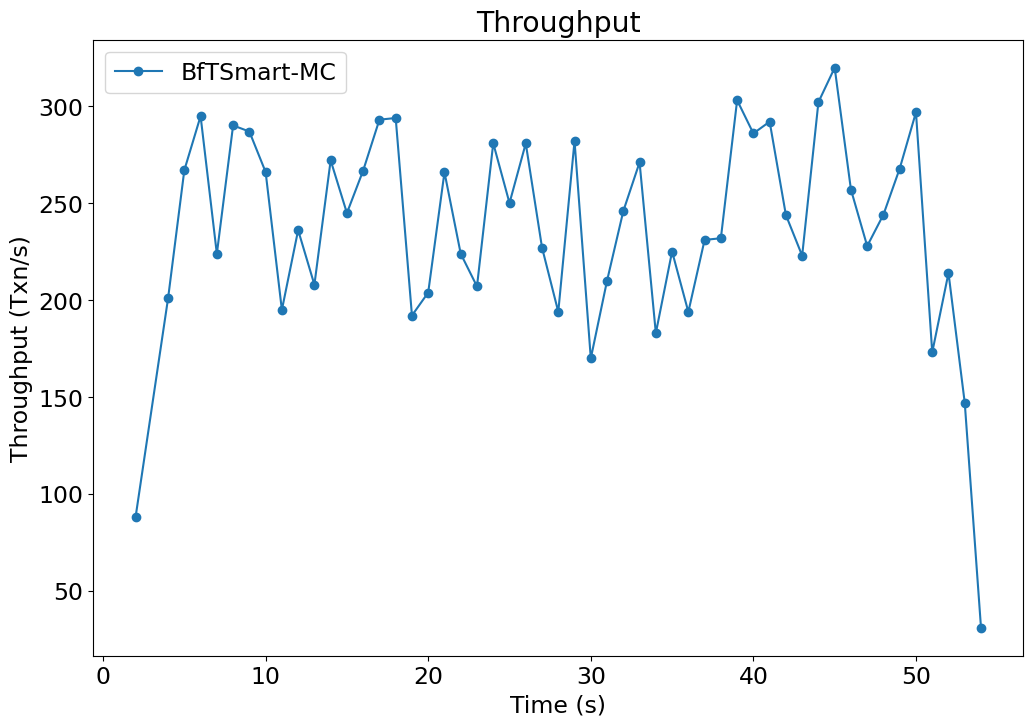

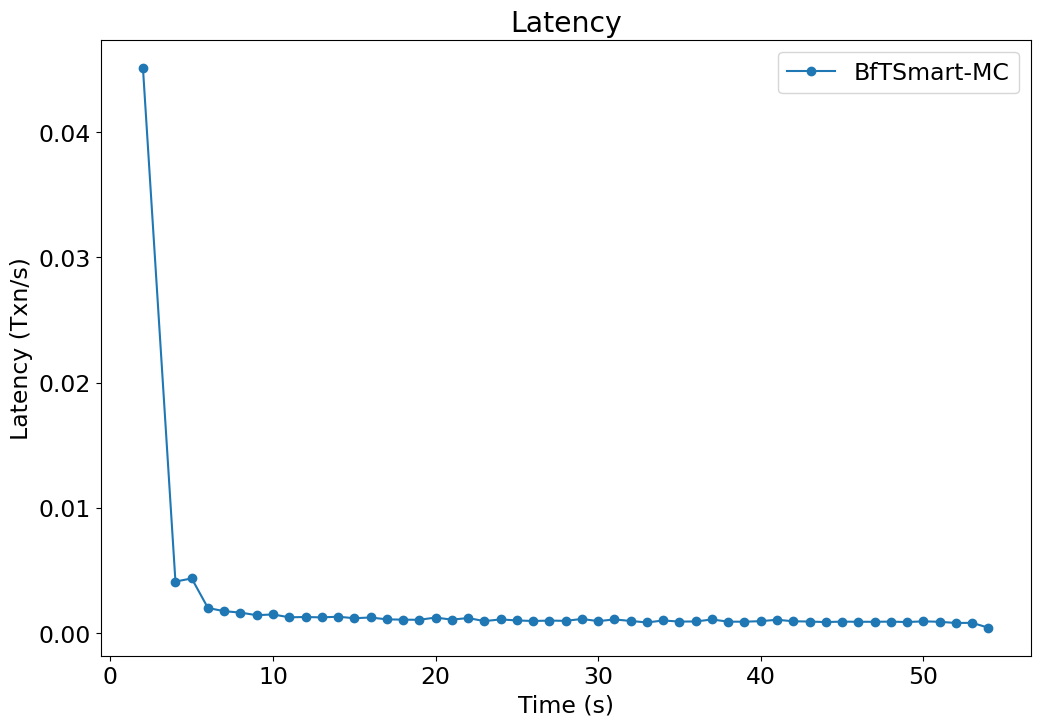

/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/pr

0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'europe-west3-c'
12 12  'europe-west3-c'
13 13  'europe-west3-c'
14 14  'europe-west3-c'
15 15  'europe-west3-c'
16 16  'europe-west3-c'
17 17  'europe-west3-c'
18 18  'europe-west3-c'
19 19  'europe-west3-c'
20 20  'asia-south1-c'
21 21  'asia-south1-c'
22 22  'asia-south1-c'
23 23  'asia-south1-c'
24 24  'asia-south1-c'
25 25  'asia-south1-c'
26 26  'asia-south1-c'
27 27  'asia-south1-c'
28 28  'asia-south1-c'
29 29  'asia-south1-c'
30 30  'asia-south1-c'


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-24].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-11].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-17].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-20].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instanc

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-17  europe-west3-c  e2-highmem-2               10.156.0.38  34.159.63.63  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-24  asia-south1-c  e2-highmem-2               10.160.0.12  35.200.207.90  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-30].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-15].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-20  asia-south1-c  e2-highmem-2               10.160.0.23  34.93.255.193  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-11  europe-west3-c  e2-highmem-2               10.156.0.32  35.246.193.35  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-19  europe-west3-c  e2-highmem-2               10.156.0.115  35.242.204.167  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-23].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-30  asia-south1-c  e2-highmem-2               10.160.0.33  34.93.134.53  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.40  34.159.126.10  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.114  34.141.91.29  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.120  34.159.77.117  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.113  34.89.200.81  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-15  europe-west3-c  e2-highmem-2               10.156.0.41  34.107.0.56  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-29].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-23  asia-south1-c  e2-highmem-2               10.160.0.96  34.93.61.222  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-22].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.37  34.159.23.30  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-29  asia-south1-c  e2-highmem-2               10.160.0.38  34.100.223.48  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-18].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.118  35.198.105.85  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-13].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-25].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-22  asia-south1-c  e2-highmem-2               10.160.0.97  34.100.162.153  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-18  europe-west3-c  e2-highmem-2               10.156.0.34  34.89.226.117  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-26].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.33  34.107.45.189  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-25  asia-south1-c  e2-highmem-2               10.160.0.100  34.100.186.190  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-13  europe-west3-c  e2-highmem-2               10.156.0.44  34.107.79.172  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-26  asia-south1-c  e2-highmem-2               10.160.0.36  35.244.15.197  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-16].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-12].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.0.30  34.107.80.212  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-28].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.36  34.89.133.102  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-14].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.121  35.198.69.222  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-16  europe-west3-c  e2-highmem-2               10.156.0.116  35.198.143.168  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-21].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.35  34.89.178.12  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP  STATUS
resdb-12  europe-west3-c  e2-highmem-2               10.156.0.119  34.107.4.43  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-28  asia-south1-c  e2-highmem-2               10.160.0.43  34.100.226.208  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-21  asia-south1-c  e2-highmem-2               10.160.0.101  35.200.204.131  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-14  europe-west3-c  e2-highmem-2               10.156.0.117  34.141.113.196  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-27].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20231213'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-27  asia-south1-c  e2-highmem-2               10.160.0.99  35.200.207.247  RUNNING
test:  7001 10.156.0.34
test:  7002 10.156.0.115
test:  7003 10.160.0.33


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 811ms
3 actionable tasks: 3 executed


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 386ms
1 actionable task: 1 executed

----------

test:  0 10.156.0.36 10000 20000 0

test:  1 10.156.0.33 10000 20000 0

test:  2 10.156.0.118 10000 20000 0

test:  3 10.156.0.40 10000 20000 0

test:  4 10.156.0.30 10000 20000 0

test:  5 10.156.0.120 10000 20000 0

test:  6 10.156.0.114 10000 20000 0

test:  7 10.156.0.35 10000 20000 0

test:  8 10.156.0.121 10000 20000 0

test:  9 10.156.0.113 10000 20000 0

test:  10 10.156.0.37 10000 20000 0

test:  11 10.156.0.32 10000 20000 0

test:  12 10.156.0.119 10000 20000 0

test:  13 10.156.0.44 10000 20000 0

test:  14 10.156.0.117 10000 20000 1

test:  15 10.156.0.41 10000 20000 1

test:  16 10.156.0.116 10000 20000 1

test:  17 10.156.0.38 10000 20000 1

test:  18 10.160.0.23 10000 20000 1

test:  19 10.160.0.101 10000 20000 1

test:  20 10.160.0.97 10000 20000 1

test:  21 10.160.0.96 10000 20000 1

test:  22 10.160.0.12 10000 20000 1

test:  23 10.160.0.100 10000 20000 1

test:  24 10.160.0.36 10000 

To github.com:tmane002/BftSmart_Final.git
   0bf501b1..c88353e7  main -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-36.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-33.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-118.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-40.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-30.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-120.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-114.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-35.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-121.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-113.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-37.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-32.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-119.us-west-1.co

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning in

Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 P

Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRel

Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [488 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe 

Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:16 http://europe-west3.gce.archi

Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Metadata [17.2 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2569 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:17 http://europe-west3.gce.archive.u

Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://europe-west3.gce.archive.ubun

Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:24 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [405 kB]
Get:25 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:26 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2451 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]
Get:27 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [342 kB]

Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [359 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1142 kB]
Get:18 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-update

Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2640 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Tr

Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:40 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:41 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:42 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5504 B]
Get:4 http://asia-south1.gce.archive.ubuntu.

Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7484 B]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [273 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [25.8 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.

Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-

Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [916 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3021 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.6 kB]
Get:41 http://security.ubuntu.com/ubuntu f

Reading package lists...
Building dependency tree...
Reading state information...

Fetched 29.7 MB in 7s (4467 kB/s)
Reading package lists...

Fetched 29.7 MB in 6s (5174 kB/s)
Reading package lists...Reading package lists...

Reading state information...
Building dependency tree...Reading package lists...Reading package lists...
Building dependency tree...
Building dependency tree...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-brid


Reading package lists...

The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfe


Building dependency tree...The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless

Reading state information...

Reading state information...
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 l


Reading package lists...Building dependency tree...
Reading state information...


Building dependency tree...Reading package lists...
Reading state information...
Reading package lists...
Building dependency tree...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
Building dependency tree...The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-c


Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Reading package lists...  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphi

Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers openjdk-11-jre openjdk-11-jre-headless x11-common
  x11-utils
0 upgraded, 77 newly installed, 0 to remove and 68 not upgraded.
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Reading package lists...
Building dependency tree...
The following NEW packages will be installed:
  

Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-co

Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev

Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
Reading package list

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:
 

Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-ja

Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-d

1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils

Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]

Reading state information...
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-lib

Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-169.187 [1125 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [192 kB]
1 upgraded, 41 newly installed, 0 to remove and 67 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be

Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
Fetched 29.7 MB in 6s (5204 kB/s)
Reading package lists...Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  


Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]

Reading state information...
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.7 [3380 B]
Get:41 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpag



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Suggested packages:
  cups-common liblcms2-utils pcscd lm-sensors libnss-mdns fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
  mesa-utils
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libway

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]

Reading state information...Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]

Get:40 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libat

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.7 [1614 kB]
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Selecting previously unselected package binutils-common:amd64.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1

dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Selecting previously unselected package binutils-common:amd64.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libbinutils:a

Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Selecting previously unselected package binutils-common:amd64.
Get:6 http://asia-south1.gce

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-common:amd64.
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libcrypt-dev:amd64.
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Selecting previously unselected package binutils.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking binutils (2.34-6ubuntu1.7) ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
(Reading database ... 62221 files and directories currently ins

Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Selecting previously unselected package libc-dev-bin.
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Get:41 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Select

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize fro

Selecting previously unselected package libcrypt-dev:amd64.
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-

Unpacking libisl22:amd64 (0.22.1-1) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Unpacking binutils (2.34-6ubuntu1.7) ...
Get:

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Selecting previously unselected package libmpc3:amd64.
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu foc

Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Unp

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Fetched 48.2 MB in 2s (29.0 MB/s)
Fetched 48.2 MB in 4s (11.4 MB/s)
Selecting previously unselected package libmpc3:amd64.
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Selecting previously unselected package libmpc3:amd64.
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)Unpacking libmpc3:amd64 (1.1.0-1) ...
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]

debconf: falling back to frontend: Readline
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Get:16 http://asia-south1.gce.archiv

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 62221 files and directories currently installed.)

Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package cpp-9.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.3

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libctf0:amd64.
Selecting previously unselected package libgomp1:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Preparing to un

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously un

Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previou

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libctf-nobfd0:amd64.
Fetched 48.2 MB in 3s (18.4 MB/s)
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.7_amd64.deb ...
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils.
Unpacking binutils (2.34-6ubuntu1.7) ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.7_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking binutils (2.34-6ubuntu1.7) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp.
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libc-

Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-169.187_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.7) ...
Unpacking linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package cpp-9.
Selecting previously unselected package libctf0:amd64.
(Reading database ... 62221 files and directories currently installed.)
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.7_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Unpacking cpp-9 (9.4.0-1ubuntu1~20

Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package binutils-x86-64-linux-gnu.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.7_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Selecting previo

Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package cpp-9.
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package gcc-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libmpc3:amd64.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu

Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.

Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package g++-9.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libcrypt-dev:a

Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package cpp-9.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.0

Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Unpacking liblsan0:

Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package cpp.
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libdpkg-perl.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...

Selecting previously unselected package libgcc-9-dev:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselec

Selecting previously unselected package gcc-9.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package build-essential.
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.7) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_

Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++-9.
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package manpages-dev.
Selecting previously unselected package libgcc-9-dev:amd64.
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Selecting previously unselected package g++.
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb

Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Selecting previously unselected package gcc.
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting pre

Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package build-essential.
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Selecting previously unselected package libubsan1:amd64.
Setting up 

Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Setting up manpages-dev (5.05-1) ...
Selecting previously unselected package gcc.
Selecting previously unselected package libdpkg-perl.
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package dpkg-dev.
Selecting previously unselected package make.
Selecting previously unselected package build-essential.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu

Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Selecting previously unselected package manpages-dev.
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Selecting previously unselected package libalgorithm-diff-perl.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking li

Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Unpacking make (4.2.1-1.2) ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Reading package lists...
Setting up fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected package libdpkg-perl.
Setting up li

Selecting previously unselected package dpkg-dev.
Setting up linux-libc-dev:amd64 (5.4.0-169.187) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Setting up libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Unpacking build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.7) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) 

Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package manpages-dev.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package libfile-fcntllock-perl.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblock

Setting up libisl22:amd64 (0.22.1-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up make (4.2.1-1.2) ...
Selecting previously unselected package libalgorithm-merge-perl.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package libfakeroot:amd64.
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking 

Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up build-essential (12.8ubuntu1.1) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcc1-0:amd64 (

Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up manpages-dev (5.05-1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.7 [207 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.7 [473 kB]
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.7 [47.9 kB]
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.7 [46.6 kB]
Get:6 http://europe-

Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.7) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up manpages-dev (5.05-1) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (34.8 MB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.7_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.7) ...
Selecting previously unselected packa

Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.7) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.7) ...
Setting up binutils (2.34-6ubuntu1.7) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
update-alter

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 396 kB in 0s (4958 kB/s)
Fetched 396 kB in 0s (4562 kB/s)

Reading state information...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 396 kB in 0s (4440 kB/s)
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...

Reading state information...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 396 kB in 0s (5081 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...

Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Fetched 396 kB in 0s (5173 kB/s)
Setting up curl (7.68.0-1ubuntu2.21) ...

Reading state information...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Reading state information...
Fetched 396 kB in 0s (5150 kB/s)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 95%
(Reading database ... 67840 files and directories currently installed.)
Building dependency tree...
Reading state information...
Reading package lists...Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Building dependency tree...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libbloc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
(Reading database ... 67840 files and directories currently installed.)
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Fetched 396 kB in 0s (4662 kB/s)
The following additiona

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Fetched 396 kB in 0s (5234 kB/s)
Setting up curl (7.68.0-1ubuntu2.21) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)

Building dependency tree...
Reading state information...
Reading package lists...Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Setting up curl (7.68.0-1ubuntu2.21) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 l

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
The following additional packages will be installed:
  libcurl4
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting u

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osyso

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`    

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconf

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontcon


Reading state information...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for man-db (2.9.1-1) ...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
(Reading database ... 80%ading database ... 70%
Reading state information...(Reading database ... 85%
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig

0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.         

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 43.0 MB in 1s (47.6 MB/s)
Selecting previously unselected package ca-certificates-java.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Fetched 396 kB in 0s (5386 kB/s)
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
The following packages were automatically installed and are no longer requir

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Fetched 43.0 MB in 1s (46.5 MB/s)
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...

Reading state information...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...

Reading state information...
Selecting previously unselected package java-common.
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Preparing to unpack .../01

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Fetched 396 kB in 1s (510 kB/s)
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking fonts-dejavu-core (2.37-1) ...
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Fetched 396 kB in 0s (5050 kB/s)
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package libavahi-client3:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unp

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Selecting previously unselected package fonts-dejavu-c

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



Reading state information...Selecting previously unselected package fontconfig-config.

Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...

Reading state information...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
2 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Selecting previously unselected package java-common.
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previous

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Selecting previously unselected package libavahi-client3:amd64.

Reading state information...Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...

Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 's

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Selecting previously unselected package libcups2:amd64.
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Selecting previously unselected package libgraphite2-3:amd64.
The following packages will be upgraded:
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
  curl libcurl4
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...

Reading state information...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected pack

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package libjpeg8:amd64.
Reading package lists...
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libcups2:amd64.
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh. 

Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package fontconfig-config.
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre cups-common
  liblcms2-utils pcscd libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-hea

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Reading package lists...Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco

           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libava

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Selecting previously unselected package ca-certificates-java.
(Reading database ... 55%
Reading state information...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up curl (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Processing triggers for man-db (2.9.1-1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
Setting up curl (7.68.0-1ubuntu2.21) ...
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-

Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Fetched 43.0 MB in 1s (40.3 MB/s)
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libgraphite2-3:amd64.
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://a

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 h

The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Selecting previously unselected package fontconfig-config.
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 l

job.sh: 12: sdk: not found


Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected packag

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Fetched 43.0 MB in 1s (49.5 MB/s)

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN       

Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Selecting previously unselected package libcups2:amd64.
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 f

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Selecting previously unselected package libjpeg8:amd64.
Unpacking fonts-dejavu-core (2.37-1) ...
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Fetched 43.0 MB in 1s (43.0 MB/s)
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Fetched 43.0 MB in 3s (14.1 MB/s)
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected packa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package liblcms2-2:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package libpcsclite1:amd64.
0 upgraded, 19 newly installed, 0 to remove and 65 not upgraded.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Fetched 43.0 MB in 1s (54.6 MB/s)
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...Selecting previously unselected package libfontconfig1:amd64.
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...

Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package lib

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Selecting previously unselected package libavahi-common-data:amd64.
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Selecting previously unselected package java-common.
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Fetched 43.0 MB in 3s (14.9 MB/s)
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Preparing to unpack .

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Selecting previously unselected package libharfbuzz0b:amd64.
Selecting previously unselected package libcups2:amd64.
Unp

Reading package lists...Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...

Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
update-alternatives: using /

Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up default-jre-headless (2:1.11-72) ...
Unpacking libjpeg8:amd64 (

job.sh: 12: sdk: not found


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]

Reading state information...Selecting previously unselected package fontconfig-config.

Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Selecting previously unselected package defaul

Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package ant-optional.
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up ant (1.10.7-1) ...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:Starfield_Class_2_CA.pem
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up li

Adding debian:QuoVadis_Root_CA_2.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:SecureTrust_CA.pem
Setting up ant-optional (1.10.7-1) ...
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:Security_Communication_RootCA3.pem
Updating certificates in /etc/ssl/certs...
Selecting previously unselected package liblcms2-2:amd64.
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Addi

Adding debian:E-Tugra_Certification_Authority.pem
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Adding debian:DigiCert_Trusted_Root_G4.pem
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Selecting previously unselected package default-jre-headless.
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:QuoVadis_Root_CA_2.pem
Selecting previously unselected package ant.
Adding debian:GLOBALTRUST_2020.pem
Selecting previously unselected package ant-optional.
Adding debian:Certainly_Root_E1.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:SecureTrust_CA.pem
Adding debian:DigiCert_Global_Root_G2.pemPreparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...

Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Adding debian:COMODO_Certification_Authority.pem
Unpacking ant-optional (1.10.7-1) ...
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pemUnpacking ant (1.10.7-1) ...

Adding debian:Starfield_Class_2_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:AffirmTrust_Premium_ECC.pemAdding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem

Adding debi

Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Amazon_Root_CA_4.pemAdding debian:ISRG_Root_X1.pem
Adding debian:certSIGN_Root_CA_G2.pem

Adding debian:Telia_Root_CA_v2.pem
Adding debian:AffirmTrust_Commercial.pemAdding debian:ACCVRAIZ1.pem

Adding debian:Certigna.pemAdding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem

Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:DigiCert_Trusted_Root_G4.pemAdding debian:Amazon_Root_CA_1.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:Security_Communication_ECC_RootCA1.pemAdding debian:Ent


Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Setting up java-common (0.72) ...
Adding debian:QuoVadis_Root_CA_2.pemAdding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Adding debian:ACCVRAIZ1.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem

Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:SecureTrust_CA.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:Izenpe.com.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:GTS_Root_R1.pemAdding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Trustwave_Global_Certification_Authority.pemAdding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:XRamp_Global_CA_Root.pem
Setting up default-jre-headless (2:1.11-72) ...

Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pemUnpacking ant-optional (1.10.7-1) ...
Adding debian:QuoVadis_Root_CA_3_G3.pemUnpacking libjpeg8:amd64 (8c-2ubuntu8) ...


Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pemAdding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:TeliaSonera_Root_CA_v1.pem

update-alternatives: using /us

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pemProcessing triggers for man-db (2.9.1-1) ...

done.
Adding debian:SZAFIR_ROOT_CA2.pem
Setting up ant-optional (1.10.7-1) ...
Selecting previously unselected package libavahi-client3:amd64.
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Selecting previously unselected package fontconfig-config.
Adding debian:AC_RAIZ_FNMT-RCM.pem
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Adding debian:e-Szigno_Root_CA_2017.pem
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Updating certificates in /etc/ssl/certs...
Adding debian:Actalis_Authentication_Root_CA.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:TeliaSonera_Root_CA_v1.pem
Se

Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Adding debian:Secure_Global_CA.pem
Unpacking default-jre-headless (2:1.11-72) ...
Unpacking fonts-dejavu-core (2.37-1) ...
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
done.
done.
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package libgraphite2-3:amd64.
Adding debian:Certigna.pem
Selecting previously unselected package default-jre-headless.
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Adding debian:Security_Communication_ECC_RootCA1.pemPreparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...

Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected packag

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Starfield_Class_2_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:Starfield_Class_2_CA.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Setting up liblcms2-2:amd64 (2.9-4) ...
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Setting up java-common (0.72) ...
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pemSetting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to u

Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Setting up fonts-dejavu-core (2.37-1) ...
Adding debian:Security_Communication_RootCA3.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Adding debian:Certainly_Root_R1.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pemSelecting previously unselected package ant-optional.
Unpacking liblcms2-2:amd64 (2.9-4) ...
Adding debian:QuoVadis_Root_CA_2.pem

Adding debian:GTS_Root_R4.pem
Adding debian:SecureTrust_CA.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Unpacking ant-optional (1.10.7-1) ...
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:AffirmTrust_Premium_ECC.pemAdding debian:GlobalSign_Root_E46.pem

Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA

Adding debian:Security_Communication_Root_CA.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:Izenpe.com.pem
Adding debian:GTS_Root_R1.pem
done.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:Starfield_Class_2_CA.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Setting up ant-optional (1.10.7-1) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmir

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Adding debian:QuoVadis_Root_CA_2.pem
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
Adding debian:SecureTrust_CA.pem
  libcurl4
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Selecting previously unselected package ant-optional.
Adding debian:GLOBALTRUST_2020.pem
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
The following packages will be upg

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:DigiCert_Trusted_Root_G4.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:Buypass_Class_3_Root_CA.pemSetting up liblcms2-2:amd64 (2.9-4) ...

Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Setting up default-jre-headless (2:1.11-72) ...
Setting up java-common (0.72) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:GTS_Root_R2.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem

Reading state information...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Adding debian:Certainly_Root_E1.pem
Adding debian:Certainly_Root_R1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pemAdding debian:QuoVadis_Root_CA_3_G3.pem

Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Amazon_Root_CA_4.pemSelecting previously unselected package ant-optional.

Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:Certigna.pemAdding debian:AffirmTrust_Networking.pem
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Unpacking ant-optional (1.10.7-1) ...

Adding debian:QuoVadis_Root_CA_2.pem
Adding debian

Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:DigiCert_

Reading state information...
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Adding debian:ACCVRAIZ1.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:vTrus_Root_CA.pem
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:CA_Disig_Root_R2.pem
Setting up

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pemAdding debian:CFCA_EV_ROOT.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:Security_Communication_Root_CA.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem

Adding debian:Autoridad_de_Certificacion_Fir

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Updating certificates in /etc/ssl/certs...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Reading package lists...Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem

Building dependency tree...
Reading state information...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem0 added, 0 removed; done.
Running hook

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pemAdding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem

Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Trustwave_Global_Certification_Authority.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:AffirmTrust_Premium_ECC.pemAdding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem


done.
done.
Adding debian:Amazon_Root_CA_3.pem
Adding debian:QuoVadis_Root_CA

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Izenpe.com.pem
Reading package lists...Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pemdone.
done.


Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
done.
done.
Adding debian:USERTrust_RSA_Certification_Authority.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Building dependency tree...Adding debian:AffirmTrust_Networking.pem
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Setting up ant-optional (1.10.7-1) ...
Selecting previously unselected package ant.
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Processing triggers for man-db (2.9

Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Cert

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Actalis_Authentication_Root_CA.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Reading package lists...Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem

Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Building dependency tree...done.
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Setting up ant-optional (1.10.7-1) ...

do

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Unpacking ant (1.10.7-1) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-tu

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
job.sh: 12: sdk: not found


Reading package lists...Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Building dependency tree...Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
done.
done.
S

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bi

Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Reading package lists...Adding debian:QuoVadis_Root_CA_1_G3.pemReading package lists...

Reading state information...

Adding debian:SwissSign_Gold_CA_-_G2.pem

Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Building dependency tree...Adding debian:Amazon_Root_CA_3.pem
Building dependency tree...Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Setting up ant (1.10.7-1) ...
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Adding debian:Actalis_Authentication_Root_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:TeliaSonera_Root_CA_v1.pemupdate-alternatives: using /usr

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Selecting previously unselected package ant-optional.

Reading state information...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblock

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Setting up fonts-dejavu-core (2.37-1) ...
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
iputils-ping is already the newest version (3:20190709-3).
iputils

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem

Reading state information...
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem

Reading state information...
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...

Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...

Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...

Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.p

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Processing triggers for man-db (2.9.1-1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
Reading package lists...
Building dependency tree...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


iputils-ping is already the newest version (3:20190709-3).
iputils-ping set to manually installed.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...

Reading state information...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-c

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_R

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.10%...........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
20%.............Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...30%......10%.......40%...........Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.......50%......................60%.......................70%........20%...

.............100%
.
Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

.50%.......Starting a Gradle Daemon (subsequent builds will be faster)
....50%.....40%.90%......
Welcome to Gradle 7.1!..

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

................60%................60%..
Welcome to Gradle 7.1!100%


Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

50%........Starting a Gradle Daemon (subsequent builds will be faster)
.......70%.....
Welcome to Gradle 7.1!

Here are the highlights of this release:
 -

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 32s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 33s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 33s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 33s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 33s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava
> Task :jar


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 execu

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 39s
3 actionable tasks: 3 executed
.....................10%.....................10%..........20%............10%...........10%...........30%.20%........................10%..........40%........20%.30%.....................50%.20%...................40%....................60%..30.%.........20%............50%..........30%.....70%.............................40%.......60%.40%.....30%...80%...................................70%...50%......50%...90%........................40%............80%..........100%
60%...60%........................50%.........90%...70%.......70%.........................60%........100%....
.80%............80%.......70%.............90%...................90%...80%............100%
..............100%
.90%........10%......100%
.........20%...........30%..........40%...........50%

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 38s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process fou

[main a3d7ba59] Working with modified ClusterInfo
 1 file changed, 28435 insertions(+), 15 deletions(-)


To github.com:tmane002/BftSmart_Final.git
   c88353e7..a3d7ba59  main -> main
java: no process found
java: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
java: no process found
hotstuff-app: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-clie

Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
Updating c88353e7..a3d7ba59
Fast-forward
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)


From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   c88353e7..a3d7ba59  main       -> origin/main


Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Updating c88353e7..a3d7ba59
Fast-forward
 cre_exp_gc.ipynb | 28450 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 28435 insertions(+), 15 deletions(-)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will b

> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 13s
3 actionable tasks: 3 up-to-date
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 12s
3 actionable tasks: 3 up-to-date


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'config0/currentView'rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.0.35, 10.156.0.35
-- getConnection HERE 
-- Connection refused (SocketException) with remoteid:0
-- getConnection HERE 
-- Connection refused (SocketException) with remoteid:1
-- getConnection HERE 
-- Connection refused (SocketException) with remoteid:2
-- getConnection HERE 
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- Reached here inside Server Connection
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:4  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:5  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Conn

-- Sent CID reply to replica 10 with ID 3
-- <-- receiving, msg:bftsmart.statemanagement.standard.StandardSMMessage@da21a44 with it being OtherClusterMessage=false
-- currentConsensusIdAsked activated
-- Received CID query from 11 with ID 0
-- Going to send back response to CID query with CID: -1
-- --> 3: sending SystemMessage message from: bftsmart.statemanagement.standard.StandardSMMessage@39eee624 -> [11]
-- Sending message from:7 -> to:11.
-- Sent CID reply to replica 11 with ID 0
-- <-- receiving, msg:bftsmart.statemanagement.standard.StandardSMMessage@64b08f69 with it being OtherClusterMessage=false
-- currentConsensusIdAsked activated
-- Received CID query from 11 with ID 1
-- Going to send back response to CID query with CID: -1
-- --> 3: sending SystemMessage message from: bftsmart.statemanagement.standard.StandardSMMessage@79ddc981 -> [11]
-- Sending message from:7 -> to:11.
-- Sent CID reply to replica 11 with ID 1
-- <-- receiving, msg:bftsmart.statemanagement.standard.Sta

XXXXXXXX Started Clients XXXXXXXXXXXX


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-client: no process fou

-- Sending message from:0 -> to:8.
-- Sending message from:0 -> to:3.
-- Sending message from:0 -> to:6.
-- Sending message from:0 -> to:4.
-- Sending message from:0 -> to:10.
-- <-- receiving, msg:type=WRITE, number=356, epoch=0, from=9 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 9, type: 44782, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=WRITE, number=356, epoch=0, from=9
-- I'm at consensus 356 and my last consensus is 355
-- Message for consensus 356 can be processed
-- Processing paxos msg with id 356
-- Processing consensusMessage from: 9, type: 44782, propose, write, accept: 44781, 44782, 44783
-- <-- receiving, msg:type=ACCEPT, number=356, epoch=0, from=0 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 0, type: 44783, propose, write, accept: 44781, 44782, 4

-- saving msg for execution, with tid: 357, requests: [[[1008:-2069158473:45]]]
-- <-- receiving, msg:type=ACCEPT, number=357, epoch=0, from=5 with it being OtherClusterMessage=false
-- ConsensusMessage being processed MessageHandler
-- Delivering ConsensusMessage from: 5, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ------CHECKING LIMITS----------
-- Received message  type=ACCEPT, number=357, epoch=0, from=5
-- I'm at consensus -1 and my last consensus is 357
-- Out of context msg with id 357, type: 357
-- <-- receiving, msg:type=ACCEPT, number=357, epoch=0, from=6 with it being OtherClusterMessage=false
-- Ending MC for cId:357,  MCLatency: 1216545
-- ConsensusMessage being processed MessageHandler
-- Main LOOP othermsgs_received_mc for tid: 357, is temp size, nclusters is 1, 2, temp keyset [0]
-- othermsgs_received_mc for tid: 357, is temp size, nclusters is 1, 2, temp keyset [0]
-- Delivering ConsensusMessage from: 6, type: 44783, propose, write, accept: 44781, 44782

rm: cannot remove '*': No such file or directory
rm: cannot remove 'cre_setup_1_scale_2_node_infocre_t_28_clusters_2.png': No such file or directory


client copying id=  18
gcloud compute scp --zone "europe-west3-c" resdb-18:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_2_node_infocre_t_28_clusters_2/nohup_client_0.out
client copying id=  19
gcloud compute scp --zone "europe-west3-c" resdb-19:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_2_node_infocre_t_28_clusters_2/nohup_client_2.out
client copying id=  30
gcloud compute scp --zone "asia-south1-c" resdb-30:/home/tejas/nohup_client.out ../Experiments/cre_setup_1_scale_2_node_infocre_t_28_clusters_2/nohup_client_1.out
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
client copying id=  18
19
client copying id=  19
20
21
22
23
24
25
26
27
28
29
30
client copying id=  30
 2 sec: 13 operations; 12.99 current ops/sec; [READ AverageLatency(us)=91230] 
 91230 12.99 2
 4 sec: 101 operations; 88 current ops/sec; [READ AverageLatency(us)=8592.08] [UPDATE AverageLatency(us)=1373072.36] -- Receiving reply from 3 with reqId:18. Putting on pos=3
 8592.08 88 4
 5 se

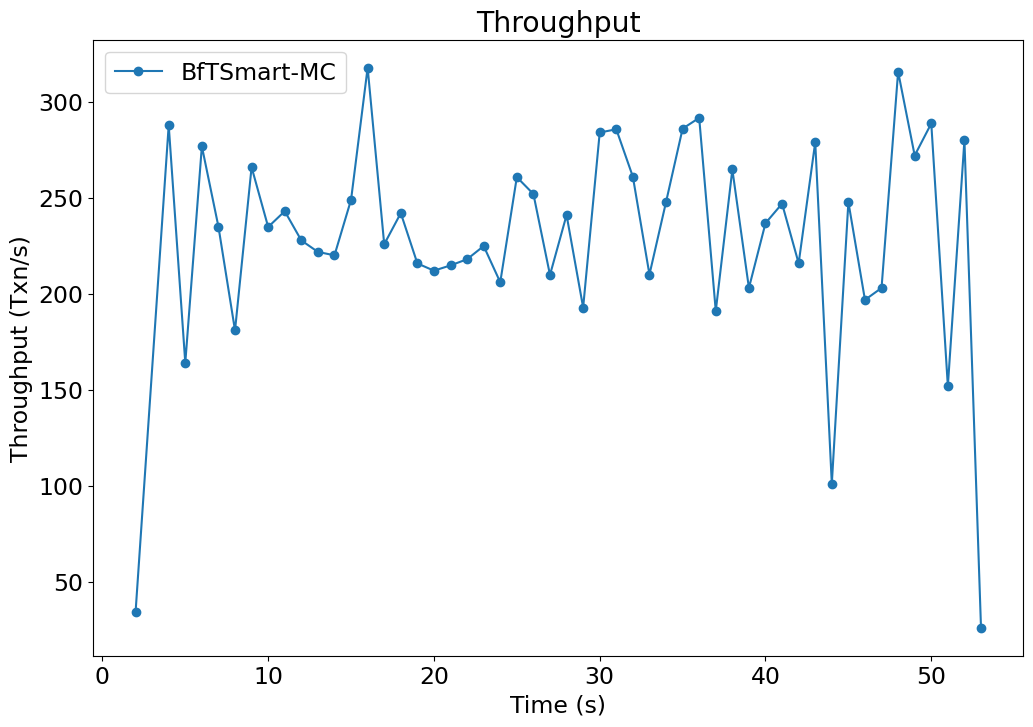

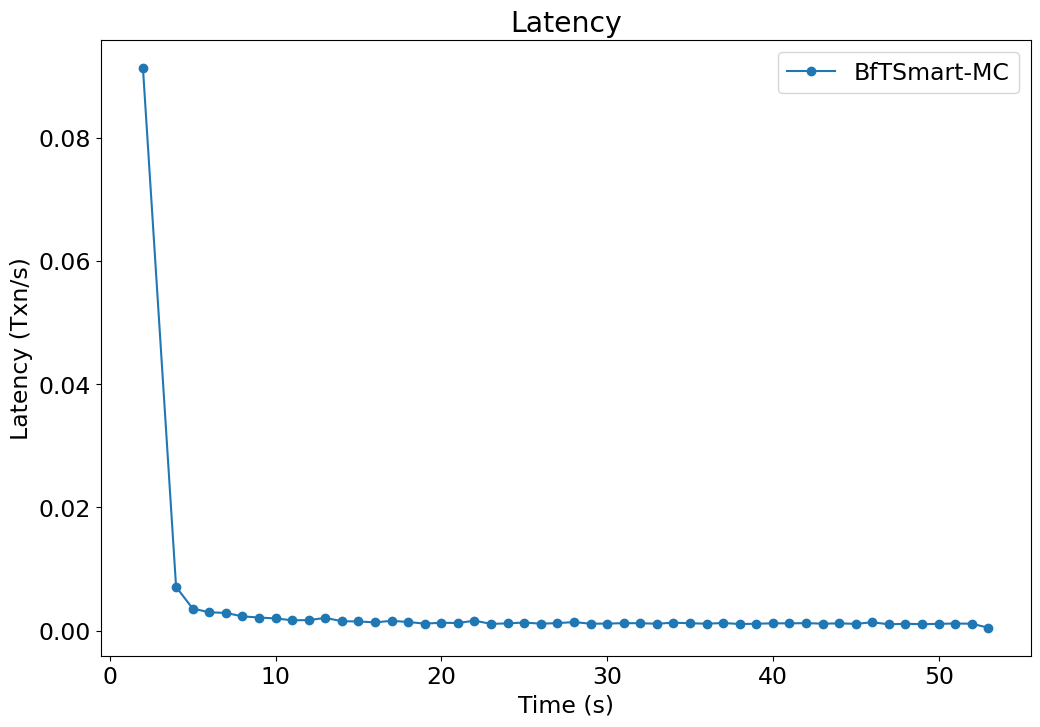

/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/pr

In [ ]:
# # %%notify

for cfig in config_list:
    
    
    run_bftsmart_mc(cfig)
    
    
    os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
    os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
    os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')